<a href="https://colab.research.google.com/github/harshith7823/CS760-Project/blob/reetu/part1/pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [2]:
def fill_death_col(clinical_data):
  
  male_obese = (clinical_data['Sex'] == 1) & (clinical_data['BMI'] > 30)
  female_obese = (clinical_data['Sex'] == -1) & (clinical_data['BMI'] > 30)
  male_underweight = (clinical_data['Sex'] == 1) & (clinical_data['BMI'] < 18.5)
  female_underweight = (clinical_data['Sex'] == -1) & (clinical_data['BMI'] < 18.5)
  clinical_data['BMI_reduction_factor'] = 0
  clinical_data.loc[male_obese, 'BMI_reduction_factor'] = 4.2
  clinical_data.loc[female_obese, 'BMI_reduction_factor'] = 3.5
  clinical_data.loc[male_underweight, 'BMI_reduction_factor'] = 4.3
  clinical_data.loc[female_underweight, 'BMI_reduction_factor'] = 4.5

  clinical_data['Tobacco_reduction_factor'] = np.where(clinical_data['Tobacco']==1,10,0)

  
  #Leave na on rows with no death data, fill the rest with age*365+death days 
  clinical_data['Age_at_death'] = np.where(clinical_data['DEATH [d from CT]'].isna(), np.nan, clinical_data['Age at CT']*365 + clinical_data['DEATH [d from CT]'])
  
  # fill death with avg lifespan - alpha(reduction for tobacco) - beta(reduction for bmi)
  corr_bmi_death = clinical_data['BMI'].corr(clinical_data['Age_at_death'])
  corr_tobacco_death = clinical_data['Tobacco'].corr(clinical_data['Age_at_death'])

  # print(corr_bmi_death)
  # print(corr_tobacco_death)

  #normalize
  alpha = corr_bmi_death/(corr_bmi_death+corr_tobacco_death)
  beta = corr_tobacco_death/(corr_bmi_death+corr_tobacco_death)

  # print(alpha)
  # print(beta)
  
  avg_lifespan_male=76.3  
  avg_lifespan_female=81.2

  clinical_data['avg_life'] = np.where(clinical_data['Sex']==1, avg_lifespan_male, avg_lifespan_female)
  clinical_data['avg_life'] = clinical_data['avg_life'] - alpha*(clinical_data['BMI_reduction_factor'])-beta*(clinical_data['Tobacco_reduction_factor'])
  clinical_data['DEATH [d from CT]'].fillna((clinical_data['avg_life']-clinical_data['Age at CT'])*365, inplace=True)
  
  clinical_data.drop(columns=['Age_at_death'], inplace=True) #only used for correlation, we dont need this any further
  return clinical_data


In [55]:
def preprocess_clinical_data(oppScrData, mean=True):
    clinical_data = oppScrData.filter(['BMI','BMI >30', 'Sex', 'Tobacco', 'Met Sx', 'FRAX 10y Fx Prob (Orange-w/ DXA)',
                                'FRAX 10y Hip Fx Prob (Orange-w/ DXA)','FRS 10-year risk (%)', 'Age at CT', 'DEATH [d from CT]'], axis=1)
    # Replace all _,X,blanks with nan
    clinical_data = clinical_data.replace(r'_', np.nan, regex=True)
    clinical_data = clinical_data.replace(r'X', np.nan, regex=True)
    clinical_data = clinical_data.replace(r'^\s*$', np.nan, regex=True)

    # Fill na in bmi column with mean
    clinical_data['BMI'].fillna(value=clinical_data['BMI'].mean(skipna=True), inplace=True)
    
    # Fill na in bmi>30 column based on bmi col
    clinical_data.loc[clinical_data.BMI>30, 'BMI >30'] = 1
    clinical_data.loc[clinical_data.BMI<=30, 'BMI >30'] = -1
    
    clinical_data['Sex'] = np.where(clinical_data['Sex']=='Male',1,-1)
    clinical_data['Met Sx'] = np.where(clinical_data['Met Sx']=='Y',1,-1) 

    # Treat no data in tobacco as no tobacco usage 
    clinical_data['Tobacco'] = np.where(clinical_data['Tobacco']=='Yes',1,-1) 
  
    clinical_data['FRS 10-year risk (%)'] = clinical_data['FRS 10-year risk (%)'].replace("<1", 0.01, regex=True)
    clinical_data['FRS 10-year risk (%)'] = clinical_data['FRS 10-year risk (%)'].replace(">30", 0.30, regex=True)
    clinical_data['FRS 10-year risk (%)'] =  clinical_data['FRS 10-year risk (%)'] * 100
 
    cols_to_be_filled = ['FRAX 10y Fx Prob (Orange-w/ DXA)','FRAX 10y Hip Fx Prob (Orange-w/ DXA)','FRS 10-year risk (%)']
    for c in cols_to_be_filled:
      if mean:  
        clinical_data[c].fillna(value=clinical_data[c].mean(skipna=True), inplace=True)
      else :
        clinical_data[c].fillna(value=clinical_data[c].median(skipna=True), inplace=True)

    clinical_data = fill_death_col(clinical_data)

    return [clinical_data, np.array(clinical_data, dtype=np.float32)]

In [9]:
def clean_ct_data(oppScrData):
    # Delete rows with empty values
    ct_data= oppScrData[["L1_HU_BMD", "TAT Area (cm2)", 'Total Body                Area EA (cm2)',
       'VAT Area (cm2)', 'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston',
       'Liver HU    (Median)', 'Age at CT']]
    n = ct_data.shape[0]
    preprocessed_ct_data = []
    for i in range(n):
        row = ct_data.loc[i]
        ignore = False
        for j in row:
          if pd.isna(j) or j == ' ': # There is an empty string somewhere in Liver column
            ignore = True
            break
        if not ignore:
          preprocessed_ct_data.append(row)
    return [preprocessed_ct_data, np.array(preprocessed_ct_data, dtype=np.float32)]

In [5]:
def normalize_ss(data):
  return StandardScaler().fit_transform(data)

In [6]:
oppScrData = pd.read_excel (r'sample_data/OppScrData.xlsx') 

In [71]:
clinical_data, clinical_data_np = preprocess_clinical_data(oppScrData)
ct_data, ct_data_np = clean_ct_data(oppScrData)

In [72]:
scaled_clinical_data = normalize_ss(clinical_data_np)
scaled_ct_data = normalize_ss(ct_data_np)

ValueError: ignored

In [50]:
def get_pca_components(X_scaled):

  pca = PCA(n_components = 0.90)
  pca.fit(X_scaled)
  print("Cumulative Variances (Percentage):")
  print(np.cumsum(pca.explained_variance_ratio_ * 100))
  components = len(pca.explained_variance_ratio_)
  print(f'Number of components: {components}')

  plt.plot(range(1, components + 1), np.cumsum(pca.explained_variance_ratio_ * 100))
  plt.xlabel("Number of components")
  plt.ylabel("Explained variance (%)")

  pca_components = abs(pca.components_)
  print('Top 4 most important features in each component')
  print('===============================================')
  print(pca_components.shape[0])
  for row in range(pca_components.shape[0]):
      # get the indices of the top 4 values in each row
      temp = np.argpartition(-(pca_components[row]), 4)
      
      # sort the indices in descending order
      indices = temp[np.argsort((-pca_components[row])[temp])][:4]
      
      # print the top 4 feature names
      print(f'Component {row}: {clinical_data.columns[indices].to_list()}')

  X_pca = pca.transform(X_scaled)
  print(X_pca.shape)
  print(X_pca)

Cumulative Variances (Percentage):
[38.82823  56.21955  69.662186 77.45952  84.0457   90.220245]
Number of components: 6
Top 4 most important features in each component
6
Component 0: ['Sex', 'BMI >30', 'Tobacco', 'Age at CT']
Component 1: ['Tobacco_reduction_factor', 'FRAX 10y Hip Fx Prob (Orange-w/ DXA)', 'BMI', 'FRS 10-year risk (%)']
Component 2: ['FRAX 10y Fx Prob (Orange-w/ DXA)', 'Met Sx', 'DEATH [d from CT]', 'Tobacco_reduction_factor']
Component 3: ['FRAX 10y Fx Prob (Orange-w/ DXA)', 'Age at CT', 'FRS 10-year risk (%)', 'BMI_reduction_factor']
Component 4: ['BMI', 'DEATH [d from CT]', 'Tobacco_reduction_factor', 'FRAX 10y Fx Prob (Orange-w/ DXA)']
Component 5: ['BMI_reduction_factor', 'FRAX 10y Fx Prob (Orange-w/ DXA)', 'Tobacco', 'BMI >30']
(8878, 6)
[[ 0.5431541   1.14574    -1.0881952   0.12993622  1.1898476  -0.05414548]
 [ 0.23840317 -0.566128   -2.0962431   0.59360194  1.3476809   0.27830836]
 [ 0.2898434  -0.29023513  1.6320162  -1.613295    0.2610719  -0.3733894 ]
 ..

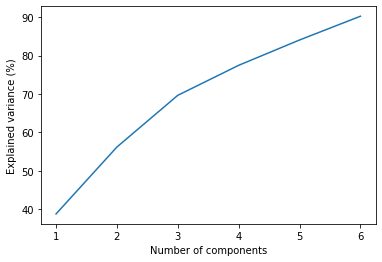

In [73]:
get_pca_components(scaled_ct_data)

Cumulative Variances (Percentage):
[30.3108   55.179276 70.84769  83.684555 89.64145  94.23144 ]
Number of components: 6
Top 4 most important features in each component
6
Component 0: ['avg_life', 'BMI_reduction_factor', 'BMI >30', 'FRS 10-year risk (%)']
Component 1: ['FRAX 10y Fx Prob (Orange-w/ DXA)', 'Age at CT', 'FRAX 10y Hip Fx Prob (Orange-w/ DXA)', 'DEATH [d from CT]']
Component 2: ['Tobacco_reduction_factor', 'Tobacco', 'Sex', 'BMI >30']
Component 3: ['Tobacco_reduction_factor', 'Tobacco', 'Sex', 'FRS 10-year risk (%)']
Component 4: ['Met Sx', 'BMI >30', 'BMI_reduction_factor', 'FRS 10-year risk (%)']
Component 5: ['FRAX 10y Hip Fx Prob (Orange-w/ DXA)', 'Age at CT', 'DEATH [d from CT]', 'FRAX 10y Fx Prob (Orange-w/ DXA)']
(9223, 6)
[[ 3.0375826   0.40284324  1.8753098  -1.726313   -1.3533915  -0.7402995 ]
 [ 0.91608626 -0.31158528  1.8971316  -0.4279476  -0.9475057  -0.8484209 ]
 [-2.0979176  -0.8804851   0.15682599 -0.27817133  0.23427534 -0.33987367]
 ...
 [ 1.8221583  -1.0

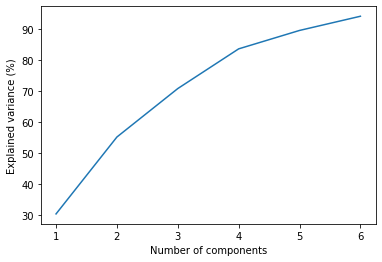

In [74]:
get_pca_components(scaled_clinical_data)